Fishing Statistics in North Carolina

Stephanie Albornoz, Justin Tung

Both of us enjoy fishing to a certain degree, Stephanie loves visiting North Carolina every summer, her family lives very close to the Ocean close to the intracoastal area and she regularly goes out fishing with her family as a pastime and Justin goes out fishing with his family occasionally during breaks from school. One thing that we have noticed is the inconsistency when we go out fishing, the range of fish we've caught over multiple trips ranges from 0 all the way up to 13. We wanted to understand a little more about the inconsistency and find out potential factors that affected our success (or lack of). These factors included things like: fishing experience, weather, time, method of fishing, etc.

Thankfully for us, the National Oceanic and Atmospheric Administration (NOAA) surveys anglers when they come back from their fishing trips and has publicized the information. Their survey includes lots of data on the factors that we wanted to explore about fishing that we mentioned above. 

In our tutorial, we will be analyzing the data provided by the NOAA. We will be observing how different factors affect fishing success, analyzing certain trends in the data and using Machine Learning algorithms to predict whether this year's fishing will improve, and by how much, and what would be the best time to go fish to enjoy this year's summer fishing season.

Tools needed:

In [ ]:
import pandas as pd
from random import sample
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import time, timedelta,datetime,date
import math
import statsmodels.formula.api as sm

Introduction to our Data:

We are going to be using one of the NOAA Fisheries official recreational fishing data sets, the data set variables and naming conventions can be pretty confusing, so here is an overlook:

We will be using one of the Trip-Level Data sets, which has records of an angler trip interview. The naming conventions of the Trip-Level Data sets use TRIP_YYYYW, where YYYY is the year, and "W" is the "Wave". For the NOAA, the "Wave" is a 2 month sampling period. Because summer break for most colleges is mid May to late August, we will be using TRIP_20214, TRIP20204, TRIP20194, TRIP20184. This means we will be using wave 4, which contains the months of July/August, of the most recent entries in the dataset from 2018 through 2021. This will also help us since there are a massive amount of entries in the dataset, so specifying certain aspects will allow us to focus more on what we wanted to learn.

Cleaning and Getting Our Data:

First we will read all the CSV files of angler trip surveys performed from 2018-2021 during the months of July/August and put each into a dataframe for cleaning.

In [ ]:
tmp_full_df1 = pd.read_csv(r'./trip_20213.csv', low_memory = False)
tmp_full_df2 = pd.read_csv(r'./trip_20203.csv', low_memory = False)
tmp_full_df3 = pd.read_csv(r'./trip_20193.csv', low_memory = False)
tmp_full_df4 = pd.read_csv(r'./trip_20183.csv', low_memory = False)

Then we will edit the temporary dataframes of each year so they only include the data for ocean fishing in the North Carolina area (NC_AREA). We chose to focus on North Carolina since Stephanie has more fishing experience and could potentially relate to the data a bit more. To keep only the data relevant to us, we run this code:

In [ ]:
tmp_full_df1 = tmp_full_df1.dropna(subset=['AREA_NC'])
tmp_full_df2 = tmp_full_df2.dropna(subset=['AREA_NC'])
tmp_full_df3 = tmp_full_df3.dropna(subset=['AREA_NC'])
tmp_full_df4 = tmp_full_df4.dropna(subset=['AREA_NC'])
#Since the NOAA marks "1" as the code for ocean fishing, we will only keep this subset
tmp_full_df1 = tmp_full_df1[tmp_full_df1.AREA_NC == "1"]
tmp_full_df2 = tmp_full_df2[tmp_full_df2.AREA_NC == "1"]
tmp_full_df3 = tmp_full_df3[tmp_full_df3.AREA_NC == "1"]
tmp_full_df4 = tmp_full_df4[tmp_full_df4.AREA_NC == "1"]

tmp_full_df1 = tmp_full_df1[['CATCH','HRSF','kod','TIME','GEAR','MODE_F','FFDAYS12','YEAR']]
tmp_full_df2 = tmp_full_df2[['CATCH','HRSF','kod','TIME','GEAR','MODE_F','FFDAYS12','YEAR']]
tmp_full_df3 = tmp_full_df3[['CATCH','HRSF','kod','TIME','GEAR','MODE_F','FFDAYS12','YEAR']]
tmp_full_df4 = tmp_full_df4[['CATCH','HRSF','kod','TIME','GEAR','MODE_F','FFDAYS12','YEAR']]

In our dataframes above, we have 8 columns of data. We keep track of:

Catch:

HRSF: 

Kod:

Time:

Gear:

Mode_F:

FFDAYS12:

Year:



As we mentioned earlier, fishing is a very inconsistent sport, at least for people who fish casually. Sometimes a person can fish for several hours and catch nothing while another person can fish for a short period of time and catch multiple fish. As a result, the dataset is filled with many entries where people have varying amounts of fish caught. We want to be able to compare the success of different fisherman, even if they fished for different amounts of time. To do this, we will add a new column to each dataframe, and with that column we can see how "successful" an angler was compared to another.

In this tutorial, we will determine success as the amount of fish catched divided by the amount of hours spent to catch said fish, so catching the most amount of fish over the least amount of time implies a higher "success" fishing trip.

In [ ]:
tmp_full_df1["succ_hr"] = tmp_full_df1["CATCH"]/ tmp_full_df1["HRSF"]
tmp_full_df2["succ_hr"] = tmp_full_df2["CATCH"]/ tmp_full_df2["HRSF"]
tmp_full_df3["succ_hr"] = tmp_full_df3["CATCH"]/ tmp_full_df3["HRSF"]
tmp_full_df4["succ_hr"] = tmp_full_df4["CATCH"]/ tmp_full_df4["HRSF"]

We are now able to compare how successful each of the anglers' trips were, but we have a new issue to think about. Our dataset is too large to work with, we have too many entries. As much as we would like to include all the entries in the dataset for accuracy, there are simply too many entries each year for us to work with.

In [ ]:
print("In fact each of the temporary dataframes sizes are")
print(tmp_full_df1.size,tmp_full_df2.size,tmp_full_df3.size,tmp_full_df4.size)

In fact each of the temporary dataframes sizes are
24651 36549 23859 30105


To combat our problem and for the sake of optimism, we will narrow down our analysis to the most successful fishing trips and ignore any entries that could not be computed from a missing hours fished value. Furthermore, for each dataframe we will only grab the top 1000 performers, with all of their entries at that index together and merge them into a dataframe for the years 2018-2021. This way we will have a much more manageable dataset to work with.

In [ ]:
tmp_full_df1,tmp_full_df2= tmp_full_df1.dropna(subset=['succ_hr']),tmp_full_df2.dropna(subset=['succ_hr'])
tmp_full_df3,tmp_full_df4= tmp_full_df3.dropna(subset=['succ_hr']),tmp_full_df4.dropna(subset=['succ_hr'])
tmp_full_df1 = tmp_full_df1.sort_values(by = 'succ_hr')
tmp_full_df2 = tmp_full_df2.sort_values(by = 'succ_hr')
tmp_full_df3 = tmp_full_df3.sort_values(by = 'succ_hr')
tmp_full_df4 =tmp_full_df4.sort_values(by = 'succ_hr')


tmp_full_df1,tmp_full_df2 = tmp_full_df1.iloc[:1000],tmp_full_df2.iloc[:1000]
tmp_full_df3,tmp_full_df4 = tmp_full_df3.iloc[:1000],tmp_full_df4.iloc[:1000]

tmp_dataframes = [tmp_full_df1,tmp_full_df2,tmp_full_df3,tmp_full_df4]
nc_df = pd.concat(tmp_dataframes)
nc_df

,CATCH,HRSF,kod,TIME,GEAR,MODE_F,FFDAYS12,YEAR,succ_hr
22234,1.0,12.0,wd,1749.0,1.0,8.0,15.0,2021,0.083333
21753,1.0,11.0,wd,1552.0,1.0,8.0,100.0,2021,0.090909
21752,1.0,11.0,wd,1551.0,1.0,8.0,100.0,2021,0.090909
19660,2.0,20.0,we,1814.0,1.0,1.0,25.0,2021,0.100000
19661,2.0,20.0,we,1814.0,1.0,1.0,0.0,2021,0.100000
...,...,...,...,...,...,...,...,...,...
17994,1.0,3.0,we,1231.0,1.0,8.0,200.0,2018,0.333333
16276,1.0,3.0,we,1120.0,1.0,7.0,12.0,2018,0.333333
17995,2.0,6.0,we,1332.0,1.0,8.0,0.0,2018,0.333333
17996,2.0,6.0,we,1333.0,1.0,8.0,0.0,2018,0.333333


We will also change the names of some of the columns as the NOAA trip variables can be pretty confusing and sometimes do not follow naming conventions. In addition, we will also add the time period that the individuals went fishing. NOAA's data does not directly have this information, but it does have the length of the anglers' trips as well as the time the interview took place, which will allow us to get the period of time of their trip. Knowing this, we will add a column with the time period that the anglers went fishing. 

In [ ]:
nc_df = nc_df.rename(columns={'CATCH':'num_catched','HRSF':'hrs_fished',
                      'kod':'week/weekday','TIME':'time','GEAR':'gear','MODE_F':'fishing_mode','FFDAYS12':'days_fished', 
                     'YEAR':'year'})
gear_map = {1.0: 'hook & line', 2.0 :'dip net', 3.0: 'cast net', 4.0:'Gill net', 5.0: 'Seine', 6.0: 'Trawl',7.0 : 'Trap',8.0 : 'Spear', 
            9.0 : 'Hand', 10.0 : 
            'Other', 11.0 : 'YoYo (Puerto Rico only)'}
fmode_map = {1.0 : 'Pier, dock',2.0 :'Jetty, breakwater, breachway', 3.0 : 'Bridge, causeway',4.0 : 'Other man-made', 5.0 : 'Beach or bank', 
             6.0 : 'Head boat', 7.0: 'Charter boat', 8.0 : 'Private/Rental boat'}

for i, row in nc_df.iterrows():
    if row["gear"] in gear_map:
        nc_df.at[i,'gear'] = gear_map[row["gear"]]
    if row["fishing_mode"] in fmode_map:
        nc_df.at[i,'fishing_mode'] = fmode_map[row["fishing_mode"]]
    frmt = '%H:%M'
    interview_time = str(int(row["time"]))
    if len(interview_time) <= 3:
        splice = 1
    else:
        splice = 2
    nc_df.at[i,'time'] = time(int(interview_time[:splice]),int(interview_time[splice:]),0)
    
time_start = []
for i, row in nc_df.iterrows():
    time = row["time"]
    dt = datetime.combine(date.today(),time)- timedelta(hours=row["hrs_fished"])
    time_start.append(dt.time())
        
nc_df["starting_time"] = time_start

Exploratory data analysis:

Now that we're done cleaning up our data, we can begin to conduct some analysis on it. 
People have long debated skill versus luck in the sport of fishing. With our data, we can prove or dispute whether fishing is luck or not. We will do this by checking if people who have spent more time fishing have caught more fish in comparison to inexperienced anglers. We will be using the days fished of each angler as a measurement on how experienced they are at fishing, as someone who fished more days in the year will be more experienced than someone who fished less than them.

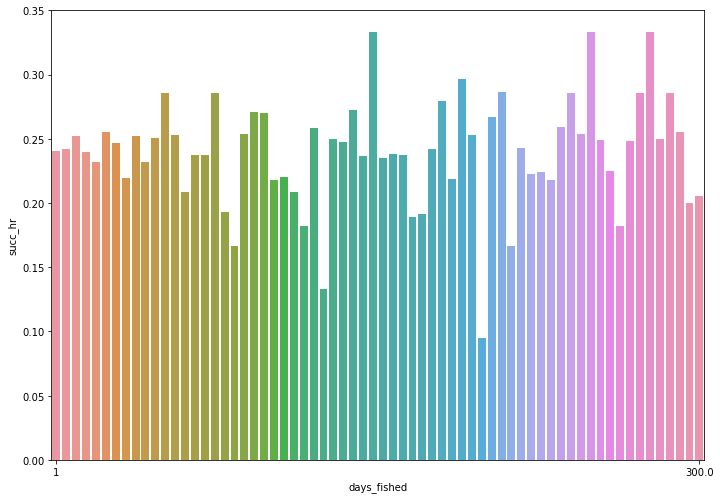

In [ ]:
nc_df['days_fished'] = nc_df['days_fished'].replace([998.0],1)
nc_df['days_fished'] = nc_df['days_fished'].replace([999.0],1)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
fig = sns.barplot(y=nc_df["succ_hr"],x=nc_df["days_fished"],ci=None, ax = ax)
size = (len(set(nc_df["days_fished"])))
fished_max = max(set(nc_df["days_fished"]))
set_ticks = plt.xticks([0, size-1], ['1', fished_max])

Sadly as it can be observed, the success rate anglers who fished nearly the maximum amount of days in the year were worse or comparable to someone who fished for significantly less days. For example, taking the extremes, people who fished only one day of the year versus three hundred days of the year, the people who fished only one day have a higher success rate. While this seems unintuitive, this gives insight on the fact that while skill is crucial to luring and catching fish, there are many other factors that affect an anglers' success on a fishing trip as well as fishing as a sport. Potential factors affecting success may include: luck, environmental conditions, and fish population.

Since skill does not appear to affect an anglers' success rate, we can analyze another aspect of the data to perhaps find a correlation. Instead, we can look at the method of fishing to see if it affects success as it could be that the way that these anglers fished could have a significant impact on how successful their trips were. 

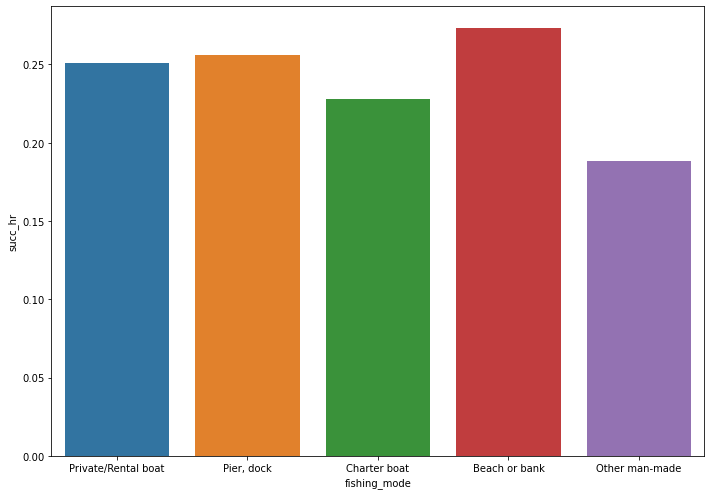

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
fig = sns.barplot(y=nc_df["succ_hr"],x=nc_df["fishing_mode"],ci=None, ax = ax)

At a glance, besides other man-made fishing spots, the method of fishing all produce similar results in terms of success rate, approximately .25 fish caught per hour. This means that it takes on average, 4 hours to catch one fish for nearly every method. It seems likely that the method for fishing does not have that large of an effect on the amount of fish an angler would catch. This also holds up with the idea that there are many factors that affect the success rate, so we would not see a specific factor drastically changing success.


Instead, let's explore the data in regards to how successful people were each year, we will see what were the most common rates at which people caught fish by the hour. This way we can also see the density at which people most commonly caught fish.

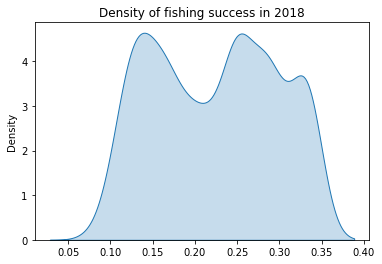

In [ ]:
curr_success = []
for i, row in nc_df.iterrows():
    if row["year"] == 2018:
        curr_success.append(row["succ_hr"])
kde = sns.kdeplot(curr_success,shade=True).set(title='Density of fishing success in 2018')

As we can see in 2018, the most commonly dense group of success rates was between 0.10-0.15, implying that it would take someone around 6-10 hours to catch a single fish, and then another peak being a success rate of 0.25-0.30, implying that it would take the angler 3-4 hours approximately to catch a fish. 

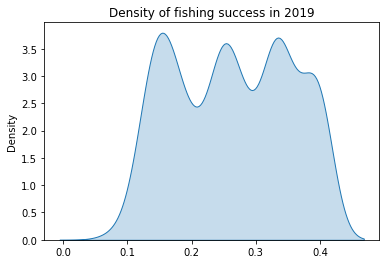

In [ ]:
curr_success = []
for i, row in nc_df.iterrows():
    if row["year"] == 2019:
        curr_success.append(row["succ_hr"])
kde = sns.kdeplot(curr_success,shade=True).set(title='Density of fishing success in 2019')

In 2019, the most commonly densed group of success rates was between 0.10-0.20, implying that it would take someone around 5-10 hours to catch a single fish, and then another peak being a success rate of 0.25, implying that it would take the angler approximately 4 hours to catch a fish, then finally we see another peak in density between 0.3-0.4 success rate, implying that another most common group would catch a fish after approximately 2.5-3 hours.

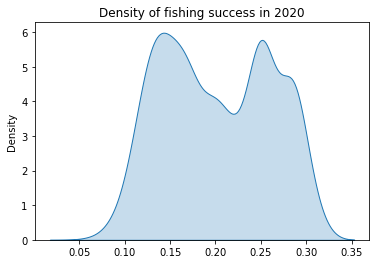

In [ ]:
curr_success = []
for i, row in nc_df.iterrows():
    if row["year"] == 2020:
        curr_success.append(row["succ_hr"])
kde = sns.kdeplot(curr_success,shade=True).set(title='Density of fishing success in 2020')

Then in 2020 it was the most commonly densed group of success rates at around 0.15, implying that it would take someone around 7 hours to catch a single fish, and then another peak being a success rate of a little over 0.25, implying that it would take the angler close to 4 hours approximately to catch a fish.

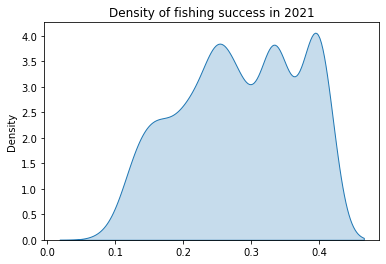

In [ ]:
curr_success = []
for i, row in nc_df.iterrows():
    if row["year"] == 2021:
        curr_success.append(row["succ_hr"])
kde = sns.kdeplot(curr_success,shade=True).set(title='Density of fishing success in 2021')

Last year in 2021, the most commonly dense group of success rates wwas approximately at 0.25, implying that it would take someone around 4 hours to catch a single fish, and then another peak being a success rate of at around 0.35, implying that it would take the angler approximately 3 hours until they caught a fish, and then another peak at a little over a rate of 0.4, implying it would
take the angler around 2.5 hours to catch one fish.

As we can see, certain years were better in terms of anglers' success on fishing trips than other years. Specifically, in 2021 there was a very noticeable shift of density towards higher success rates compared to the years before it. Another thing to note is that there were also shifts in previous years towards the most common densities of success rate. If we combine all of our density graphs we get:

                            OLS Regression Results                            
Dep. Variable:                succ_hr   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     97.41
Date:                Sat, 10 Dec 2022   Prob (F-statistic):           1.02e-22
Time:                        03:29:37   Log-Likelihood:                 4242.0
No. Observations:                4000   AIC:                            -8480.
Df Residuals:                    3998   BIC:                            -8467.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.3810      2.394     -9.768      0.0

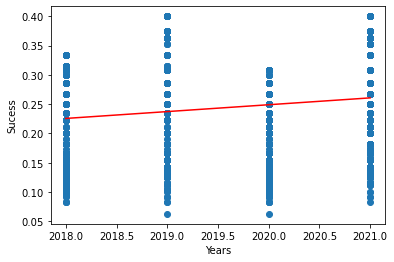

In [ ]:
x_axis = np.array(nc_df["year"]).reshape(-1,1)
y_axis = nc_df["succ_hr"]
linear_reg = LinearRegression().fit(x_axis,y_axis)
plt.scatter(nc_df["year"],nc_df["succ_hr"])
prediction = linear_reg.predict(x_axis)
plt.plot(x_axis, prediction, color = "red")
plt.xlabel("Years")
y = plt.ylabel("Sucess")
average_increase = linear_reg.coef_
info = sm.ols(formula = "succ_hr ~ year",data= nc_df).fit()
print(info.summary())

As a reminder, our null hypothesis is that there is a relation between years and the success rate of anglers. Since the P-Value in the Linear Regression is 0, we can reject the null hypothesis, meaning that there is indeed a relation between the year anglers fished and their success. 

This finding is meaningful for our own hypothesis as well. We can now say that based on data, there is a relation between our success and the time we fished. 

In [ ]:
nc_df["starting_time"]
setsy = set()
all_periods = []
for i, row in nc_df.iterrows():
    start_time,ending_time = row["starting_time"], row["time"]
    start_hr,end_hr = start_time.hour,ending_time.hour
    setsy.add(start_hr)
    setsy.add(end_hr)
    period = (start_hr,end_hr)
    all_periods.append(period)

nc_df["period_of_fishing"] = all_periods
periods_list = {}
curr_period = []
marker = 0
for i in range(0,max(setsy)+1,int(average_time)):
    curr_period.append(i)
    marker +=1
    if marker % 2 == 0:
        key = (curr_period[0],curr_period[1])
        periods_list[key] = []
        curr_period = [i]
        marker +=1
        continue
print(periods_list)
#for each time period, attach the anglers "successfulness" to that key if they were there during that time
for i, row in nc_df.iterrows():
    start_time,end_time = row["period_of_fishing"]
    for key in periods_list.keys():
        pd_start,pd_end = key
        if start_time >= pd_start and pd_end >= end_time:
            periods_list[key].append(row["succ_hr"])

curr_min = float('inf')
for i in periods_list.values():
    if len(i) != 0:
        curr_min = min(curr_min,len(i))
cleaned_list = {}

x_axis = []
y_axis = []
for i in periods_list.keys():
    if len(periods_list[i])!=0:
        periods_list[i] = sample(periods_list[i],curr_min)
        for x in periods_list[i]:
            x_axis.append(str(i))
            y_axis.append(x)

{(0, 6): [], (6, 12): [], (12, 18): []}
